# Time series and statistical analysis part 2

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pandas.testing as tm
import matplotlib as plt
from matplotlib import pyplot as plt

This notebook has the similar purpose as the notebook that discussed the first part of time series analysis. In this part statistical test are run on the data, with the augmented Dickey-Fuller test. Also time series decomposition will be implemented. It are techniques that kind of split that data into the original, trend, seasonal, and irregular components. This can determine the underlying data patterns, and whether or not the data contains any seasonality

## Dataset 1: aantallen_gemeente_cumulatief 

In [18]:
dutch_data_01 = pd.read_csv('/Users/stevenkraamwinkel/Desktop/Datasets 1 mei/COVID-19_aantallen_gemeente_cumulatief_01_05.csv', parse_dates=True, delimiter=';')
display(dutch_data_01)


,Date_of_report,Municipality_code,Municipality_name,Province,Total_reported,Hospital_admission,Deceased
0,13/03/2020 10:00,GM0003,Appingedam,Groningen,0,0,0
1,13/03/2020 10:00,GM0010,Delfzijl,Groningen,0,0,0
2,13/03/2020 10:00,GM0014,Groningen,Groningen,3,0,0
3,13/03/2020 10:00,GM0024,Loppersum,Groningen,0,0,0
4,13/03/2020 10:00,GM0034,Almere,Flevoland,1,1,0
...,...,...,...,...,...,...,...
151955,01/05/2021 10:00,NaN,NaN,Noord-Holland,668,20,2
151956,01/05/2021 10:00,NaN,NaN,Zuid-Holland,2312,46,15
151957,01/05/2021 10:00,NaN,NaN,Zeeland,56,4,1
151958,01/05/2021 10:00,NaN,NaN,Noord-Brabant,1144,29,7


In [19]:
#Selecting columns
dutch_data_01 = dutch_data_01[['Date_of_report', 'Total_reported', 'Hospital_admission', 'Deceased']]

dutch_data_01['Date_of_report']= pd.to_datetime(dutch_data_01['Date_of_report'], format='%d/%m/%Y %H:%M')
dutch_data_01 = dutch_data_01.set_index('Date_of_report')
dutch_data_01 = dutch_data_01.resample('D').sum()
dutch_data_01

,Total_reported,Hospital_admission,Deceased
Date_of_report,,,
2020-03-13,804,115,9
2020-03-14,959,136,12
2020-03-15,1135,162,19
2020-03-16,1413,205,23
2020-03-17,1705,314,40
...,...,...,...
2021-04-27,1472674,28445,17093
2021-04-28,1481323,28517,17104
2021-04-29,1488594,28580,17124


In [20]:
#From cumulative sum to daily counts

#Cumulative function found from source: 
#https://codereview.stackexchange.com/questions/117183/extracting-original-values-from-cumulative-sum-values

cumulative = dutch_data_01['Total_reported']

def B(cumulative):
    output = [0] * len(cumulative)
    for i,e in reversed(list(enumerate(cumulative))):
        output[i]=cumulative[i] - cumulative[i-1]
    output[0]=cumulative[0]
    return output

## Augmented Dickey-Fuller (ADF) test

In [21]:
from statsmodels.tsa import stattools
%matplotlib inline
from statsmodels.tsa import seasonal

In [22]:
data_01 = pd.DataFrame(B(cumulative), index = pd.date_range('03/13/2020', '05/01/2021'), columns = {'Number_of_cases'})
hyp_test_daily_cases = data_01['Number_of_cases']
display(hyp_test_daily_cases)


2020-03-13     804
2020-03-14     155
2020-03-15     176
2020-03-16     278
2020-03-17     292
              ... 
2021-04-27    5337
2021-04-28    8649
2021-04-29    7271
2021-04-30    7758
2021-05-01    5755
Freq: D, Name: Number_of_cases, Length: 415, dtype: int64

In [23]:
#Augmented Dickey-Fuller (ADF) test
adf_result = stattools.adfuller(data_01['Number_of_cases'], autolag='AIC')

print('p-val of the ADF test in COVID-19 cases:', adf_result[1])


p-val of the ADF test in COVID-19 cases: 0.3917818272517899


## Time series decomposition

In [24]:
#Run ADF test on the original time series
adf_result = stattools.adfuller(data_01['Number_of_cases'], autolag='AIC')

In [25]:
print('ADF-statistic:', adf_result[0])
print('p-val of the ADF test on irregular variations in employment data:', adf_result[1])

ADF-statistic: -1.7773131409864875
p-val of the ADF test on irregular variations in employment data: 0.3917818272517899


In [26]:
decompose_model = seasonal.seasonal_decompose(data_01.Number_of_cases.tolist(), period=12,
                                              model='additive')


(array([18334, 18353, 18383, 18414, 18444, 18475, 18506, 18536, 18567,
        18597, 18628, 18659, 18687, 18718, 18748]),
 [Text(18334, 0, ''),
  Text(18353, 0, 'Apr'),
  Text(18383, 0, 'May'),
  Text(18414, 0, 'Jun'),
  Text(18444, 0, 'Jul'),
  Text(18475, 0, 'Aug'),
  Text(18506, 0, 'Sep'),
  Text(18536, 0, 'Oct'),
  Text(18567, 0, 'Nov'),
  Text(18597, 0, 'Dec'),
  Text(18628, 0, 'Jan\n2021'),
  Text(18659, 0, 'Feb'),
  Text(18687, 0, 'Mar'),
  Text(18718, 0, 'Apr'),
  Text(18748, 0, 'May')])

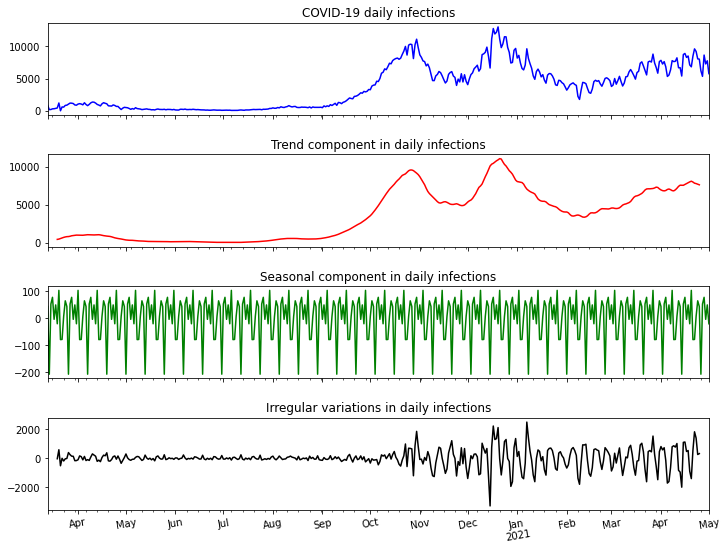

In [30]:
#Plot the original time series, trend, seasonal and random components
fig, axarr = plt.subplots(4, sharex=True)
fig.set_size_inches(10, 7.5)

data_01['Number_of_cases'].plot(ax=axarr[0], color='b', linestyle='-')
axarr[0].set_title('COVID-19 daily infections')

pd.Series(data=decompose_model.trend, index=data_01.index).plot(color='r', linestyle='-', ax=axarr[1])
axarr[1].set_title('Trend component in daily infections')

pd.Series(data=decompose_model.seasonal, index=data_01.index).plot(color='g', linestyle='-', ax=axarr[2])
axarr[2].set_title('Seasonal component in daily infections')

pd.Series(data=decompose_model.resid, index=data_01.index).plot(color='k', linestyle='-', ax=axarr[3])
axarr[3].set_title('Irregular variations in daily infections')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.xticks(rotation=10)


In [31]:
adf_result = stattools.adfuller(decompose_model.resid[np.where(np.isfinite(decompose_model.resid))[0]],
                                autolag='AIC')

In [32]:
print('ADF-statistic:', adf_result[0])
print('p-val of the ADF test on irregular variations in employment data:', adf_result[1])

ADF-statistic: -7.019903428935526
p-val of the ADF test on irregular variations in employment data: 6.584351059925292e-10


## Time series decomposition with statsmodel sm 


In [35]:
import statsmodels.api as sm
from matplotlib import pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 9


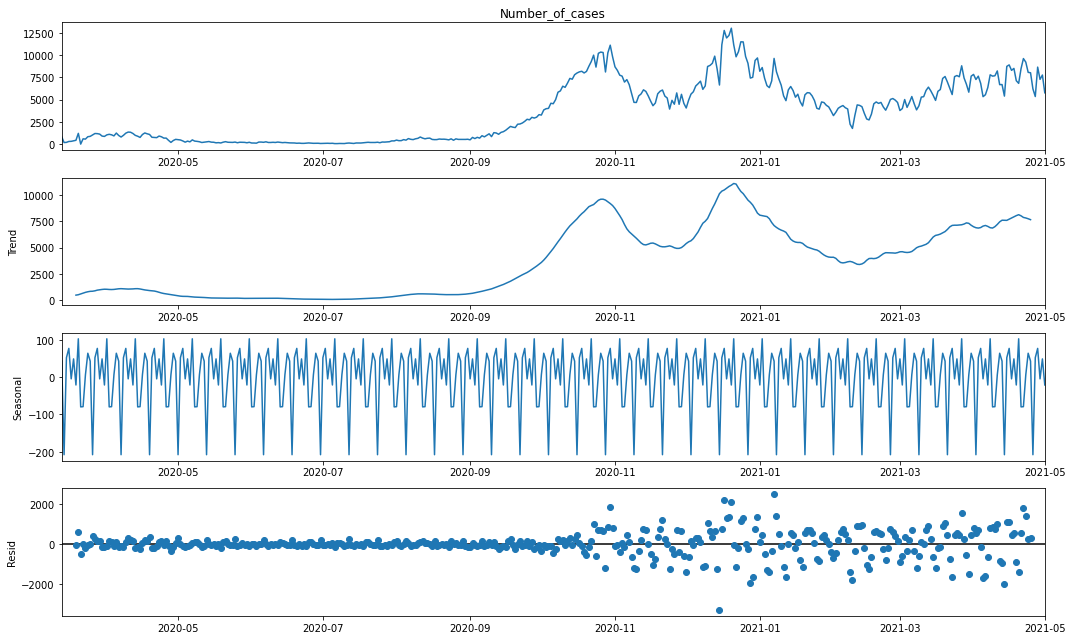

In [36]:
seasonal_decompose_res = sm.tsa.seasonal_decompose(data_01.Number_of_cases, period = 12)
seasonal_decompose_res.plot();


VERSION: 19TH OF JUNE